In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
import time

warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    roc_auc_score,
)
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [5]:
# loading data
X_train_balanced = np.load(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_train_balanced.npy"
)
y_train_balanced = np.load(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_train_balanced.npy"
)
x_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_test.csv"
)
y_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_test.csv"
)

In [7]:
# Initialize logestic regression
log_reg = LogisticRegression(
    solver="lbfgs", multi_class="ovr", max_iter=1000, random_state=42, n_jobs=-1
)

In [8]:
# traning
start_time = time.time()
log_reg.fit(X_train_balanced, y_train_balanced)
training_time = time.time() - start_time
print(f"Training time is :{training_time:.2f}")

Training time is :1.81


In [ ]:
# Prediction
y_pred_lr = log_reg.predict(x_test)
y_pred_proba_lr = log_reg.predict_proba(x_test)


In [10]:
# Evaluate logestic regression

# Overall accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Over all accuracy{accuracy_lr}")

precision_lr = precision_score(y_test, y_pred_lr, average=None, zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, average=None, zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, average=None, zero_division=0)

precision_macro_lr = precision_score(
    y_test, y_pred_lr, average="macro", zero_division=0
)
recall_macro_lr = recall_score(y_test, y_pred_lr, average="macro", zero_division=0)
f1_macro_lr = f1_score(y_test, y_pred_lr, average="macro", zero_division=0)


Over all accuracy0.9481865284974094


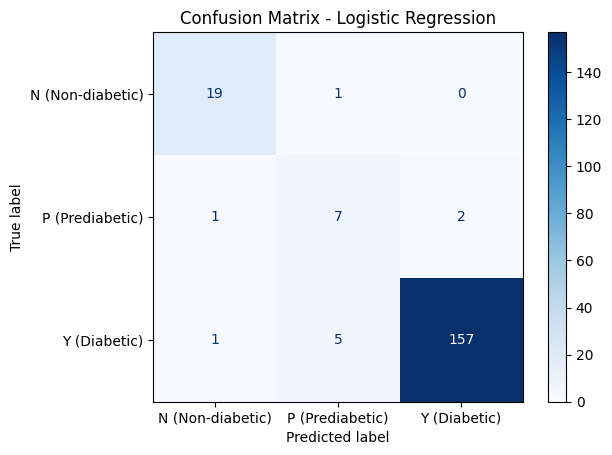

In [18]:
# Confusion Matrix
class_names = ["N (Non-diabetic)", "P (Prediabetic)", "Y (Diabetic)"]
cm_lr = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Feature Coefficients:
                Non-diabetic  Prediabetic  Diabetic
AGE                -0.364110    -0.765581  1.109760
Urea                0.496672    -0.456508  0.461999
Cr                 -0.642085     0.100935  0.483531
HbA1c              -8.624407     0.520762  2.708302
Chol               -0.582793     0.155742  0.870646
TG                 -1.186184     0.417387  0.258885
HDL                -0.161319    -0.123407  0.058296
LDL                -0.044567    -0.421536  0.148590
VLDL               -0.131235    -1.779906  1.175265
BMI                -2.949987    -0.865494  2.358524
Gender_encoded     -0.334502     0.614344 -0.384763


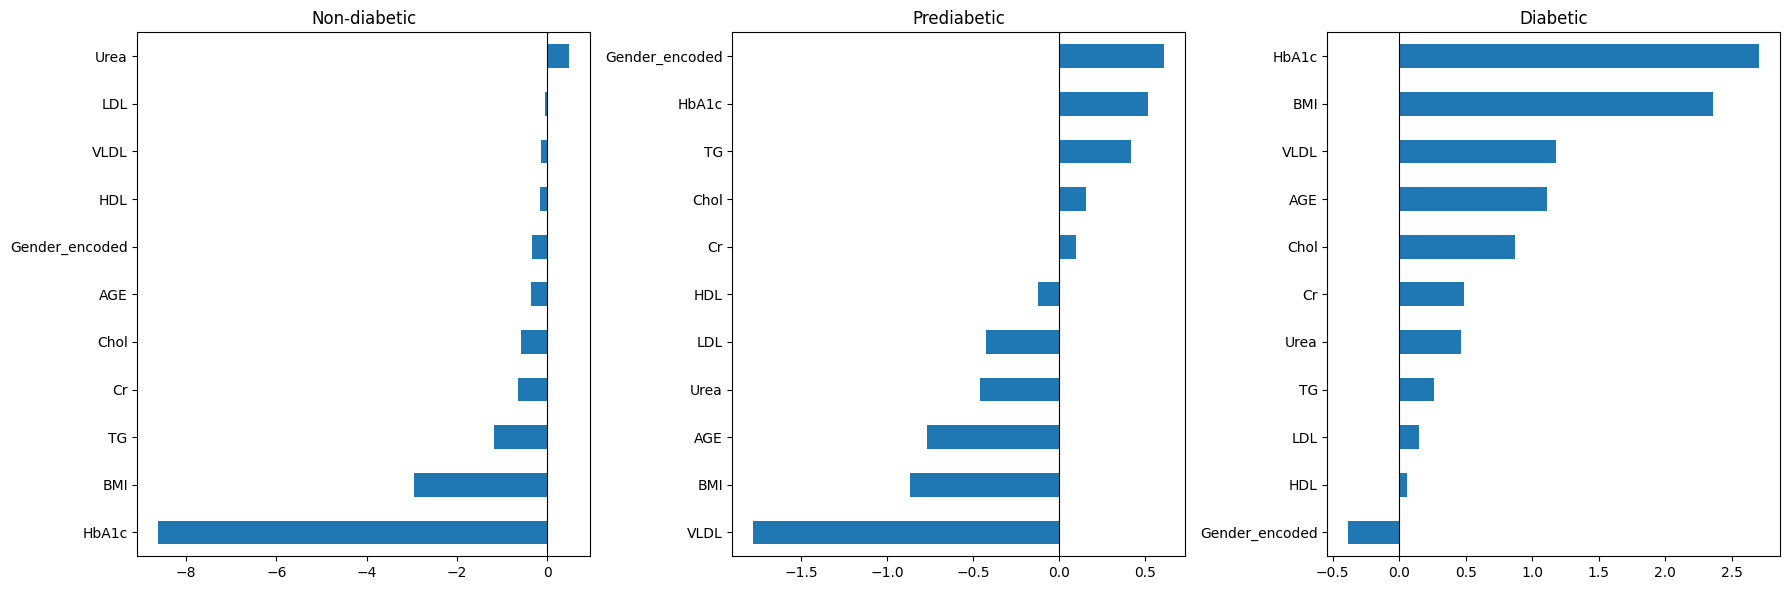

In [14]:
# Feature coefficients (shows which features are most important)
feature_names = x_test.columns
coefficients = log_reg.coef_

coef_df = pd.DataFrame(coefficients.T, columns=class_names, index=feature_names)
print("Feature Coefficients:")
print(coef_df)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, class_name in enumerate(class_names):
    coef_df[class_name].sort_values().plot(kind="barh", ax=axes[i])
    axes[i].set_title(f"{class_name}")
    axes[i].axvline(x=0, color="black", linewidth=0.8)

plt.tight_layout()
plt.show()

In [16]:
# Cross-validation to check model robustness
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    log_reg, X_train_balanced, y_train_balanced, cv=cv, scoring="f1_macro", n_jobs=-1
)

print("Cross-Validation F1-Scores:")
for fold, score in enumerate(cv_scores, 1):
    print(f"  Fold {fold}: {score:.4f}")

print(f"\nMean CV F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Test Set F1-Score: {f1_macro_lr:.4f}")

Cross-Validation F1-Scores:
  Fold 1: 0.9285
  Fold 2: 0.9434
  Fold 3: 0.9099
  Fold 4: 0.9227
  Fold 5: 0.9126

Mean CV F1-Score: 0.9234 ± 0.0120
Test Set F1-Score: 0.8369


In [ ]:
# Save model and results

# Save model
with open(
    "/home/samir-dahal/Diabetes_Classification/models/classification/logistic_regression.pkl",
    "wb",
) as f:
    pickle.dump(log_reg, f)

# Save metrics
metrics_df = pd.DataFrame(
    [
        {
            "Model": "Logistic Regression",
            "Accuracy": accuracy_lr,
            "Precision (macro)": precision_macro_lr,
            "Recall (macro)": recall_macro_lr,
            "F1-Score (macro)": f1_macro_lr,
            "F1 (N)": f1_lr[0],
            "F1 (P)": f1_lr[1],
            "F1 (Y)": f1_lr[2],
            "Training Time (s)": training_time,
            "CV F1 Mean": cv_scores.mean(),
            "CV F1 Std": cv_scores.std(),
        }
    ]
)

metrics_df.to_csv(
    "/home/samir-dahal/Diabetes_Classification/results/classification_results/classification_metrics.csv",
    index=False,
)
print("Model and metrics saved successfully")


Model and metrics saved successfully
